In [7]:
# Cleanup script for requirements.txt
clean_lines = []
with open("requirements.txt", "r") as f:
    for line in f:
        # Keep only package names and versions, remove lines with '@' or paths
        if "@" not in line:
            clean_lines.append(line.split("#")[0].strip())  # Remove comments

with open("requirements_cleaned.txt", "w") as f:
    f.write("\n".join(clean_lines))


In [2]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to parse .obj files and extract coordinates
def parse_obj_file(file_path):
    coordinates = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('v '):  # Extract vertex coordinates
                parts = line.split()
                x, y, z = map(float, parts[1:4])
                coordinates.append([x, y, z])
    return np.array(coordinates)

# Path to the root directory containing folders of individuals
root_dir = "C:/Users/thiru/Downloads/AI_VR.Datas/AI_VR.Datas"
labels = []
features = []

# Traverse through folders and parse .obj files
for individual_id, folder in enumerate(os.listdir(root_dir)):
    folder_path = os.path.join(root_dir, folder)
    if os.path.isdir(folder_path):  # Ensure it's a directory
        for obj_file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, obj_file)
            if file_path.endswith('.obj'):
                coordinates = parse_obj_file(file_path)
                
                # Feature Engineering: Example feature extraction
                velocities = []
                for i in range(1, len(coordinates)):
                    delta = coordinates[i] - coordinates[i - 1]
                    velocities.append(np.linalg.norm(delta))  # Euclidean distance
                    
                # Aggregate features (e.g., mean, std of velocities)
                features.append([np.mean(velocities), np.std(velocities)])
                labels.append(individual_id)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Standardize features for algorithms like SVM and Logistic Regression
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# List of classifiers to evaluate
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Evaluate each classifier
results = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calculate metrics (precision, recall, F1-score)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Accuracy": accuracy
    }
    print(f"{name} Results:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print(f"  Accuracy: {accuracy:.4f}\n")

# Save the best model based on F1-score
best_model_name = max(results, key=lambda x: results[x]["F1-score"])
best_model = classifiers[best_model_name]
import joblib
joblib.dump(best_model, 'best_drawing_identifier_model.pkl')
print(f"Best model saved: {best_model_name}")


Random Forest Results:
  Precision: 0.7500
  Recall: 0.6250
  F1-score: 0.6750
  Accuracy: 0.6250

Gradient Boosting Results:
  Precision: 0.7500
  Recall: 0.5000
  F1-score: 0.5625
  Accuracy: 0.5000

SVM Results:
  Precision: 0.7500
  Recall: 0.6250
  F1-score: 0.6750
  Accuracy: 0.6250

Logistic Regression Results:
  Precision: 0.7500
  Recall: 0.6250
  F1-score: 0.6750
  Accuracy: 0.6250

Decision Tree Results:
  Precision: 0.5000
  Recall: 0.2500
  F1-score: 0.3125
  Accuracy: 0.2500

Best model saved: Random Forest


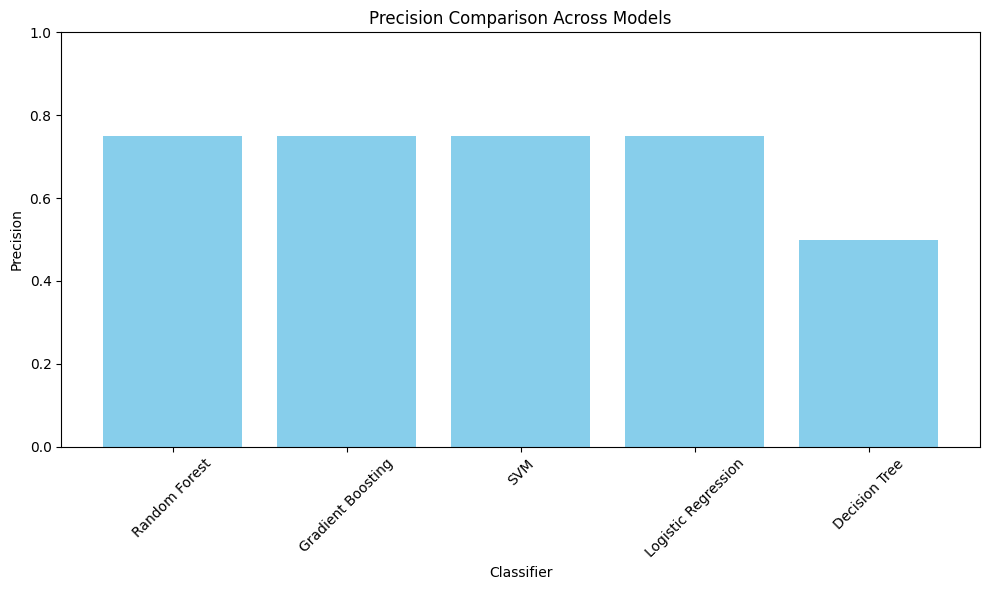

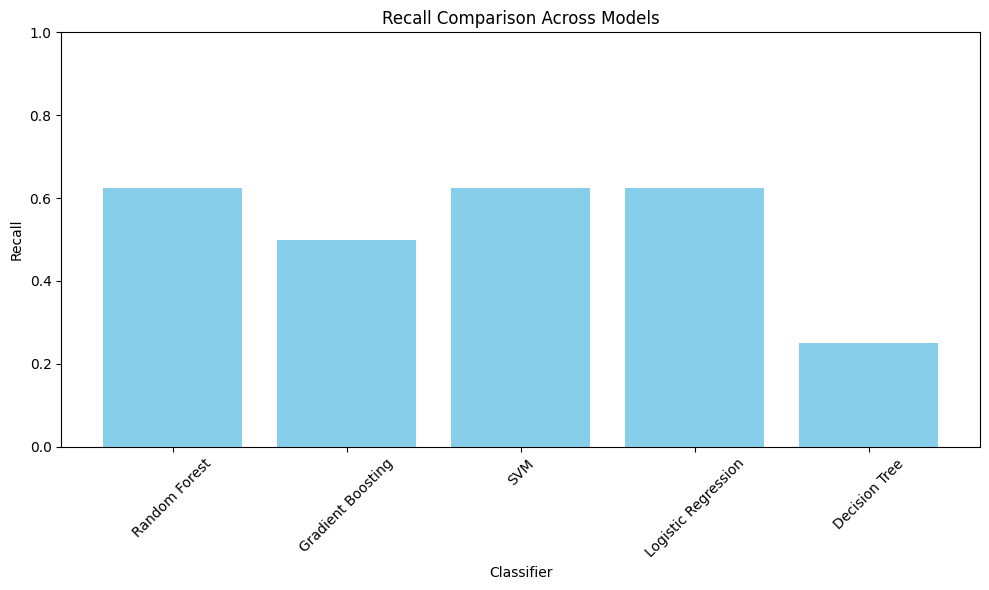

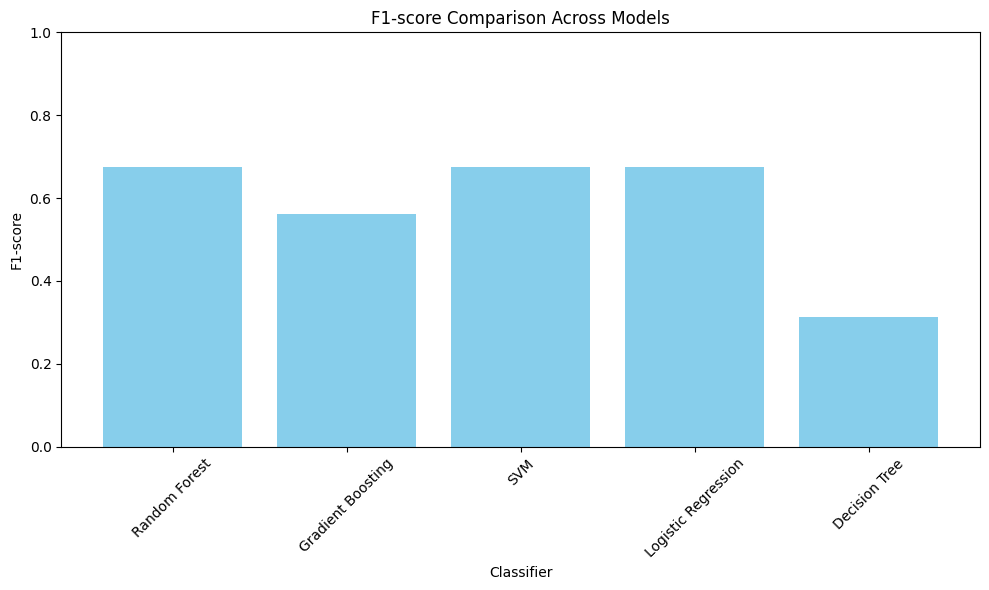

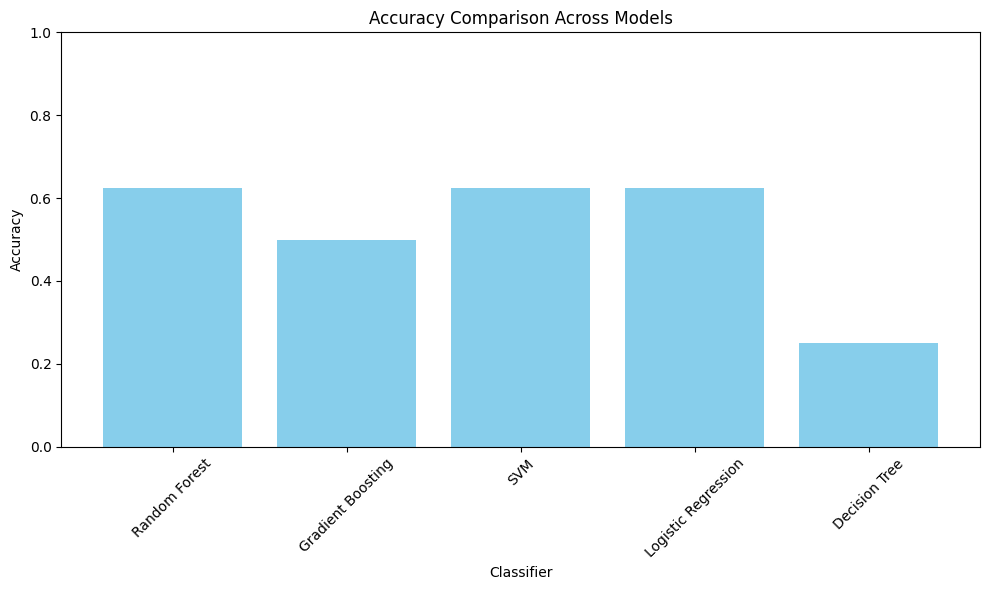

In [3]:
# Plotting metrics
def plot_metrics(results):
    metrics = ["Precision", "Recall", "F1-score", "Accuracy"]
    for metric in metrics:
        values = [results[clf][metric] for clf in results]
        plt.figure(figsize=(10, 6))
        plt.bar(results.keys(), values, color='skyblue')
        plt.title(f"{metric} Comparison Across Models")
        plt.ylabel(metric)
        plt.xlabel("Classifier")
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()

plot_metrics(results)


In [35]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [27]:
def predict_individual(model_path, input_obj_path):
    """
    Predict which individual an input .obj file belongs to.
    :param model_path: Path to the saved model file (e.g., .pkl).
    :param input_obj_path: Path to the input .obj file.
    :return: Predicted individual ID.
    """
    # Load the trained model
    classifier = joblib.load(model_path)
    
    # Parse the .obj file to extract x, y, z coordinates
    coordinates = parse_obj_file(input_obj_path)
    
    # Feature Engineering: Calculate velocities
    velocities = []
    for i in range(1, len(coordinates)):
        delta = coordinates[i] - coordinates[i - 1]
        velocities.append(np.linalg.norm(delta))  # Euclidean distance
    
    # Aggregate features (e.g., mean, std of velocities)
    input_features = np.array([np.mean(velocities), np.std(velocities)]).reshape(1, -1)
    
    # Predict using the model
    predicted_label = classifier.predict(input_features)
    return predicted_label[0]

# Example Usage
model_path = 'drawing_identifier_model.pkl'  # Path to saved model
input_obj_path = 'C:/Users/thiru/Downloads/AI_VR.Datas/AI_VR.Datas/Nilu/n7.obj.obj'     # Path to input .obj file

predicted_individual = predict_individual(model_path, input_obj_path)
print(f"The input drawing belongs to Individual {predicted_individual}")


The input drawing belongs to Individual 2


In [33]:
def predict_individual(model_path, input_obj_path, individual_names):
    """
    Predict which individual an input .obj file belongs to.
    :param model_path: Path to the saved model file (e.g., .pkl).
    :param input_obj_path: Path to the input .obj file.
    :param individual_names: Dictionary mapping individual IDs to names.
    :return: Predicted individual name.
    """
    import joblib
    
    # Load the trained model
    classifier = joblib.load(model_path)
    
    # Parse the .obj file to extract x, y, z coordinates
    coordinates = parse_obj_file(input_obj_path)
    
    # Feature Engineering: Calculate velocities
    velocities = []
    for i in range(1, len(coordinates)):
        delta = coordinates[i] - coordinates[i - 1]
        velocities.append(np.linalg.norm(delta))  # Euclidean distance
    
    # Aggregate features (e.g., mean, std of velocities)
    input_features = np.array([np.mean(velocities), np.std(velocities)]).reshape(1, -1)
    
    # Predict using the model
    predicted_label = classifier.predict(input_features)[0]
    
    # Map the predicted label to the individual's name
    predicted_name = individual_names.get(predicted_label, "Unknown")
    return predicted_name

# Map folder names to individual names
individual_names = {
    1: "Neda",
    2: "Nilu",
    3: "Sahob",
    4: "Thiru"
}

# Example Usage
model_path = 'drawing_identifier_model.pkl'  # Path to saved model
input_obj_path = 'C:/Users/thiru/Downloads/AI_VR.Datas/AI_VR.Datas/Nilu/n7.obj.obj'     # Path to input .obj file

predicted_name = predict_individual(model_path, input_obj_path, individual_names)
print(f"The input drawing belongs to: {predicted_name}")


The input drawing belongs to: Nilu


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder

# ----------------------------
# 1. Data Loading & Preprocessing
# ----------------------------
class GestureDataset(Dataset):
    def __init__(self, root_dir, grid_size=32):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.users = os.listdir(root_dir)
        self.le = LabelEncoder()
        self.data, self.labels = self._load_data()
        
    def _parse_obj(self, file_path):
        """Extract vertices from .obj file"""
        vertices = []
        with open(file_path, 'r') as f:
            for line in f:
                if line.startswith('v '):
                    parts = line.strip().split()[1:4]
                    vertices.append(list(map(float, parts)))
        return np.array(vertices)
    
    def _voxelize(self, vertices):
        """Convert 3D points to voxel grid"""
        # Normalize to [0, 1]
        min_vals = vertices.min(axis=0)
        max_vals = vertices.max(axis=0)
        normalized = (vertices - min_vals) / (max_vals - min_vals + 1e-8)
        
        # Convert to grid coordinates
        scaled = (normalized * (self.grid_size-1)).astype(int)
        voxel_grid = np.zeros((self.grid_size, self.grid_size, self.grid_size))
        
        for x, y, z in scaled:
            voxel_grid[x, y, z] = 1.0
            
        return voxel_grid
    
    def _load_data(self):
        all_data = []
        all_labels = []
        
        for user_id, user in enumerate(self.users):
            user_dir = os.path.join(self.root_dir, user)
            for obj_file in os.listdir(user_dir):
                if obj_file.endswith('.obj'):
                    file_path = os.path.join(user_dir, obj_file)
                    vertices = self._parse_obj(file_path)
                    voxel = self._voxelize(vertices)
                    all_data.append(voxel)
                    all_labels.append(user)
        
        # Encode labels
        encoded_labels = self.le.fit_transform(all_labels)
        return torch.FloatTensor(np.array(all_data)).unsqueeze(1), torch.LongTensor(encoded_labels)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# ----------------------------
# 2. 3D CNN Model
# ----------------------------
class Gesture3DCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            # Input: (1, 32, 32, 32)
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),  # 16x16x16
            
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),  # 8x8x8
            
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),  # 4x4x4
            
            nn.Flatten(),
            nn.Linear(64*4*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.net(x)

# ----------------------------
# 3. Training & Evaluation
# ----------------------------
def train_model(dataset, num_epochs=50):
    # Split dataset
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8)
    
    # Initialize model
    num_classes = len(dataset.users)
    model = Gesture3DCNN(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        print(f'Epoch {epoch+1}/{num_epochs} | Loss: {running_loss/len(train_loader):.4f}')
    
    return model

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# ----------------------------
# 4. Execution
# ----------------------------
if __name__ == "__main__":
    # Initialize dataset
    dataset = GestureDataset(root_dir='C:/Users/thiru/Downloads/AI_VR.Datas/AI_VR.Datas', grid_size=32)
    
    # Train model
    model = train_model(dataset, num_epochs=50)
    
    # Evaluate
    test_loader = DataLoader(dataset, batch_size=8)  # Or use separate test set
    final_accuracy = evaluate_model(model, test_loader)

Epoch 1/50 | Loss: 2.8616
Epoch 2/50 | Loss: 1.6194
Epoch 3/50 | Loss: 1.3701
Epoch 4/50 | Loss: 0.5815
Epoch 5/50 | Loss: 0.2591
Epoch 6/50 | Loss: 0.3278
Epoch 7/50 | Loss: 0.0456
Epoch 8/50 | Loss: 0.0984
Epoch 9/50 | Loss: 0.0211
Epoch 10/50 | Loss: 0.0958
Epoch 11/50 | Loss: 0.0300
Epoch 12/50 | Loss: 0.0086
Epoch 13/50 | Loss: 0.0075
Epoch 14/50 | Loss: 0.0688
Epoch 15/50 | Loss: 0.0056
Epoch 16/50 | Loss: 0.0046
Epoch 17/50 | Loss: 0.0051
Epoch 18/50 | Loss: 0.0153
Epoch 19/50 | Loss: 0.0072
Epoch 20/50 | Loss: 0.0069
Epoch 21/50 | Loss: 0.0037
Epoch 22/50 | Loss: 0.0080
Epoch 23/50 | Loss: 0.0016
Epoch 24/50 | Loss: 0.0019
Epoch 25/50 | Loss: 0.0008
Epoch 26/50 | Loss: 0.0026
Epoch 27/50 | Loss: 0.0045
Epoch 28/50 | Loss: 0.0059
Epoch 29/50 | Loss: 0.0040
Epoch 30/50 | Loss: 0.0004
Epoch 31/50 | Loss: 0.0019
Epoch 32/50 | Loss: 0.0008
Epoch 33/50 | Loss: 0.0009
Epoch 34/50 | Loss: 0.0014
Epoch 35/50 | Loss: 0.0006
Epoch 36/50 | Loss: 0.0011
Epoch 37/50 | Loss: 0.0010
Epoch 38/5

In [11]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')  # Force plot saving
import matplotlib.pyplot as plt

# ----------------------------
# 1. Debugged Dataset Class
# ----------------------------
class GestureDataset(Dataset):
    def __init__(self, root_dir, grid_size=32):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.users = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.le = LabelEncoder()
        self.data, self.labels = self._load_data()
        print(f"Loaded {len(self.data)} samples from {len(self.users)} users.")

    def _parse_obj(self, file_path):
        vertices = []
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    if line.startswith('v '):
                        parts = line.strip().split()[1:4]
                        vertices.append(list(map(float, parts)))
            return np.array(vertices)
        except Exception as e:
            print(f"Error parsing {file_path}: {e}")
            return np.array([])

    def _voxelize(self, vertices):
        if vertices.size == 0:
            return np.zeros((self.grid_size, self.grid_size, self.grid_size))
        min_vals = vertices.min(axis=0)
        max_vals = vertices.max(axis=0)
        normalized = (vertices - min_vals) / (max_vals - min_vals + 1e-8)
        scaled = (normalized * (self.grid_size-1)).astype(int)
        voxel_grid = np.zeros((self.grid_size, self.grid_size, self.grid_size))
        for x, y, z in scaled:
            if 0 <= x < self.grid_size and 0 <= y < self.grid_size and 0 <= z < self.grid_size:
                voxel_grid[x, y, z] = 1.0
        return voxel_grid

    def _load_data(self):
        all_data, all_labels = [], []
        for user_id, user in enumerate(self.users):
            user_dir = os.path.join(self.root_dir, user)
            if not os.path.isdir(user_dir):
                continue
            for obj_file in os.listdir(user_dir):
                if obj_file.endswith('.obj'):
                    file_path = os.path.join(user_dir, obj_file)
                    vertices = self._parse_obj(file_path)
                    if vertices.size == 0:
                        continue
                    voxel = self._voxelize(vertices)
                    all_data.append(voxel)
                    all_labels.append(user)
        if len(all_data) == 0:
            raise ValueError("No valid .obj files found!")
        encoded_labels = self.le.fit_transform(all_labels)
        return torch.FloatTensor(np.array(all_data)).unsqueeze(1), torch.LongTensor(encoded_labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# ----------------------------
# 2. Training Function with Plotting
# ----------------------------
def train_model(dataset, num_epochs=50):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8)

    num_classes = len(dataset.users)
    model = Gesture3DCNN(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_losses[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f} | "
              f"Val Acc: {val_accuracies[-1]:.2f}%")

    # Save plot to desktop
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, color='green', label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plot_path = os.path.expanduser("~/training_plot.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"\nPlots saved to {plot_path}")

    return model

# ----------------------------
# 3. Execute & Verify
# ----------------------------
if __name__ == "__main__":
    try:
        dataset = GestureDataset(root_dir='C:/Users/thiru/Downloads/AI_VR.Datas/AI_VR.Datas', grid_size=32)
        print(f"Sample voxel shape: {dataset[0][0].shape}")  # Should be (1, 32, 32, 32)
        model = train_model(dataset)
    except Exception as e:
        print(f"Error: {e}")

Loaded 40 samples from 4 users.
Sample voxel shape: torch.Size([1, 32, 32, 32])
Epoch 1/50 | Train Loss: 2.8385 | Val Loss: 1.3044 | Val Acc: 62.50%
Epoch 2/50 | Train Loss: 1.1360 | Val Loss: 1.3257 | Val Acc: 62.50%
Epoch 3/50 | Train Loss: 0.6235 | Val Loss: 1.3451 | Val Acc: 37.50%
Epoch 4/50 | Train Loss: 0.4247 | Val Loss: 1.3441 | Val Acc: 25.00%
Epoch 5/50 | Train Loss: 0.2134 | Val Loss: 1.3894 | Val Acc: 12.50%
Epoch 6/50 | Train Loss: 0.0712 | Val Loss: 1.3412 | Val Acc: 25.00%
Epoch 7/50 | Train Loss: 0.0936 | Val Loss: 1.0745 | Val Acc: 25.00%
Epoch 8/50 | Train Loss: 0.0294 | Val Loss: 0.8733 | Val Acc: 50.00%
Epoch 9/50 | Train Loss: 0.1715 | Val Loss: 0.5156 | Val Acc: 100.00%
Epoch 10/50 | Train Loss: 0.0316 | Val Loss: 0.4999 | Val Acc: 87.50%
Epoch 11/50 | Train Loss: 0.0080 | Val Loss: 0.5496 | Val Acc: 87.50%
Epoch 12/50 | Train Loss: 0.0591 | Val Loss: 0.4020 | Val Acc: 87.50%
Epoch 13/50 | Train Loss: 0.0428 | Val Loss: 0.2186 | Val Acc: 87.50%
Epoch 14/50 | Trai

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')  # Force plot saving
import matplotlib.pyplot as plt

# ----------------------------
# 1. GestureDataset
# ----------------------------
class GestureDataset(Dataset):
    def __init__(self, root_dir, grid_size=32):
        self.root_dir = root_dir
        self.grid_size = grid_size
        self.users = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.le = LabelEncoder()
        self.data, self.labels = self._load_data()
        print(f"Loaded {len(self.data)} samples from {len(self.users)} users.")

    def _parse_obj(self, file_path):
        vertices = []
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    if line.startswith('v '):
                        parts = line.strip().split()[1:4]
                        vertices.append(list(map(float, parts)))
            return np.array(vertices)
        except Exception as e:
            print(f"Error parsing {file_path}: {e}")
            return np.array([])

    def _voxelize(self, vertices):
        if vertices.size == 0:
            return np.zeros((self.grid_size, self.grid_size, self.grid_size))
        min_vals = vertices.min(axis=0)
        max_vals = vertices.max(axis=0)
        normalized = (vertices - min_vals) / (max_vals - min_vals + 1e-8)
        scaled = (normalized * (self.grid_size-1)).astype(int)
        voxel_grid = np.zeros((self.grid_size, self.grid_size, self.grid_size))
        for x, y, z in scaled:
            if 0 <= x < self.grid_size and 0 <= y < self.grid_size and 0 <= z < self.grid_size:
                voxel_grid[x, y, z] = 1.0
        return voxel_grid

    def _load_data(self):
        all_data, all_labels = [], []
        for user_id, user in enumerate(self.users):
            user_dir = os.path.join(self.root_dir, user)
            if not os.path.isdir(user_dir):
                continue
            for obj_file in os.listdir(user_dir):
                if obj_file.endswith('.obj'):
                    file_path = os.path.join(user_dir, obj_file)
                    vertices = self._parse_obj(file_path)
                    if vertices.size == 0:
                        continue
                    voxel = self._voxelize(vertices)
                    all_data.append(voxel)
                    all_labels.append(user)
        if len(all_data) == 0:
            raise ValueError("No valid .obj files found!")
        encoded_labels = self.le.fit_transform(all_labels)
        return torch.FloatTensor(np.array(all_data)).unsqueeze(1), torch.LongTensor(encoded_labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# ----------------------------
# 2. Hybrid 3D CNN + Transformer
# ----------------------------
class GestureHybridModel(nn.Module):
    def __init__(self, num_classes, grid_size=32, patch_size=4, emb_dim=128, depth=2, heads=4):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),
        )
        reduced_size = grid_size // 4
        self.patch_embed = nn.Conv3d(32, emb_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (reduced_size // patch_size) ** 3
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, emb_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        x = self.cnn(x)  # (B, 32, D', H', W')
        x = self.patch_embed(x)  # (B, emb_dim, d, h, w)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, emb_dim)
        x = x + self.pos_embed
        x = self.transformer(x)  # (B, num_patches, emb_dim)
        x = x.mean(dim=1)  # Global average pooling
        return self.classifier(x)

# ----------------------------
# 3. Training Function
# ----------------------------
def train_model(dataset, num_epochs=50):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8)

    num_classes = len(dataset.users)
    model = GestureHybridModel(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}%")

    # Save plot to desktop
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, color='green', label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plot_path = os.path.expanduser("~/training_plot.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"\nPlots saved to {plot_path}")

    return model

# ----------------------------
# 4. Execute
# ----------------------------
if __name__ == "__main__":
    try:
        dataset = GestureDataset(root_dir='C:/Users/thiru/Downloads/AI_VR.Datas/AI_VR.Datas', grid_size=32)
        print(f"Sample voxel shape: {dataset[0][0].shape}")  # Should be (1, 32, 32, 32)
        model = train_model(dataset)
    except Exception as e:
        print(f"Error: {e}")


Loaded 40 samples from 4 users.
Sample voxel shape: torch.Size([1, 32, 32, 32])
Epoch 1/50 | Train Loss: 2.4058 | Val Loss: 2.2533 | Val Acc: 12.50%
Epoch 2/50 | Train Loss: 1.6300 | Val Loss: 1.4433 | Val Acc: 25.00%
Epoch 3/50 | Train Loss: 1.4966 | Val Loss: 1.3342 | Val Acc: 25.00%
Epoch 4/50 | Train Loss: 1.4257 | Val Loss: 1.3806 | Val Acc: 37.50%
Epoch 5/50 | Train Loss: 1.3899 | Val Loss: 1.4402 | Val Acc: 12.50%
Epoch 6/50 | Train Loss: 1.3909 | Val Loss: 1.4361 | Val Acc: 25.00%
Epoch 7/50 | Train Loss: 1.3657 | Val Loss: 1.3777 | Val Acc: 25.00%
Epoch 8/50 | Train Loss: 1.3080 | Val Loss: 1.2498 | Val Acc: 62.50%
Epoch 9/50 | Train Loss: 1.1930 | Val Loss: 1.0538 | Val Acc: 62.50%
Epoch 10/50 | Train Loss: 1.0149 | Val Loss: 0.7788 | Val Acc: 75.00%
Epoch 11/50 | Train Loss: 0.8044 | Val Loss: 0.7713 | Val Acc: 62.50%
Epoch 12/50 | Train Loss: 0.8971 | Val Loss: 0.7641 | Val Acc: 62.50%
Epoch 13/50 | Train Loss: 0.6775 | Val Loss: 0.6983 | Val Acc: 50.00%
Epoch 14/50 | Train